# Übung 5

**Gruppenname:**

*TLJ*

Christian Rene Thelen, Artur Less, Karl Johannes

### Hinweise
* Nutzen Sie für die folgenden Aufgaben **nur** die Mittel, die Ihnen Numpy und Matplotlib zur Verfügung stellt. Aus didaktischen Gründen werden wir erst in der nächsten Übung Werkzeuge der Bibliothek scikit-learn einsetzen.

###  5.1 Staudamm (Teil 1) - Modellauswahl mit Hold-Out Validation

Ein Betreiber eines Staudamms hat in den vergangenen Jahren Messungen durchgeführt, die ermitteln sollen, wie viel Wasser in Abhängigkeit vom Füllstand des Stausees durch den Damm abfließen. Sie haben die Aufgabe, ein Modell zu erstellen, dass die Abflussmenge für beliebige Füllstände vorhersagt. Dazu werden Sie Validierung einsetzen, um aus mehreren Modellen ein finales Modell auszuwählen. Sie können sich unser Vorgehen auf den Folien der Vorlesung noch einmal vergegenwärtigen.

* Aus Gründen der Übersichtlichkeit ist diese Übung über mehrere Aufgaben hinweg aufgeteilt (Übung 5.1, 5.2, 5.3).

**Ihre Daten**
* Die Daten enthalten den Füllstand (x-Variablen) sowie die Wasserabflussmenge (y-Variable) in willkürlichen Einheiten.
* Ihr Datensatz ist bereits in Trainingsset (X, y), Validierungsset (Xval, yval) und Testset (Xtest, ytest) unterteilt.

**Ihre Aufgaben**

(1) Importieren Sie die Daten. Skalieren Sie die Daten folgendermaßen: Sei $x_\text{max}$ der maximale Wert der Features des Trainingssets. Dividieren Sie die Features des Trainingssets durch $x_\text{max}$ und dividieren Sie die Features des Validierungssets und des Testsets ebenfalls durch den gleichen Wert $x_\text{max}$, den Sie durch das Trainingsset erhielten. Visualisieren Sie die Trainingsdaten in einem Plot.

* Nebenbemerkungen zur Skalierung: 1. Die genaue Wahl des Wertes, mit dem Sie skalieren (hier $x_\text{max}$ und nicht etwa $|x_\text{max}|$), ist hier aus konzeptioneller Sicht nicht so wichtig. Wichtig ist, dass Sie und Ihre Kolleginnen und Kollegen dieselbe Skalierung nutzen, damit Ihre späteren Ergebnisse vergleichbar bleiben.
* Sie haben gesehen, dass Sie die Skalierung, die Sie über das Trainingsset bestimmen, so auch auf Validierungs- und Testset anwenden (das ist wichtig), und nicht etwa jedes Set separat skalieren.

In [24]:
import numpy as np
%matplotlib inline
from scipy.io import loadmat
from matplotlib import pyplot as plt
from io import BytesIO
import urllib.request

# Sie finden diese Daten auch zum Download unter: https://data.bialonski.de/ml/water-dam-data.mat
file = urllib.request.urlopen('https://data.bialonski.de/ml/water-dam-data.mat')
data = loadmat(BytesIO(file.read()))
x_train, y_train = data['X'], data['y']
x_val, y_val = data['Xval'], data['yval']
x_test, y_test = data['Xtest'], data['ytest']

# Folgender Code-Schnipsel könnte Ihnen in späteren Aufgaben hilfreich sein:
# Ermittelung der Indizes, für die ein Array A den kleinsten Eintrag enthält:
# ind = np.unravel_index(np.argmin(A, axis=None), A.shape)

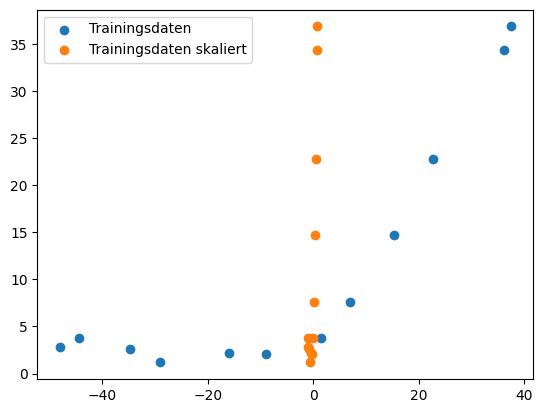

In [25]:
x_max = np.max(np.abs(x_train))

x_train_scaled = x_train / x_max

plt.scatter(x_train, y_train, label='Trainingsdaten')
plt.scatter(x_train_scaled, y_train, label='Trainingsdaten skaliert')
plt.legend(loc='upper left', fancybox=True)

x_val_scaled = x_val / x_max
x_test_scaled = x_test / x_max

(2) Wir werden diese Daten durch lineare Regression mit nonlinear feature transform modellieren. Kopieren Sie dazu Ihren Code für **regularisierte** lineare Regression (mit weigth decay) in dieses Jupyter Notebook.

In [39]:
def lin_reg_regularized(X, y, lam):
    X_1 = np.column_stack((np.ones(X.shape[0]), X))
    #X_1 = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    #X_pseudoinverse = np.linalg.inv(X_1.T @ X_1 + lam * np.identity(len(X_1.T))) @ X_1.T
    #return X_pseudoinverse @ y[:,0] 

    X_prod = X_1.T @ X_1
    if np.linalg.det(X_prod) == 0:
        raise ValueError("X^T @ X ist nicht invertierbar")
    X_pseudo = np.linalg.inv(X_prod) @ X_1.T
    return X_pseudo @ y




(3) Implementieren Sie eine Funktion $\Phi_Q$, die die x-Variablen polynomiell in einer Monomenbasis der Ordnung $Q_f$ transformiert. Das ist die nichtlineare Transformation, die Sie in der vorherigen Übung und in der vorherigen Vorlesungseinheit kennengelernt haben, und die Sie nur für beliebige Werte von $Q_f$ verallgemeinern müssen.

In [27]:
def phi(X, Q):
    # X_reshaped notwendig, da die Daten in der Form (m,1) vorliegen und nicht in der Form (m,). 
    X_reshaped = X[:,0]
    return np.array([X_reshaped**i for i in range(1, Q+1)]).T

(4) Wählen Sie $Q=8$ und erstellen Sie mittels linearer Regression (Regularisierungsparameter $\lambda=0$) einen Fit. Visualisieren Sie die Trainingsdaten sowie das Polynom, welches Sie durch die Regression erhalten haben.

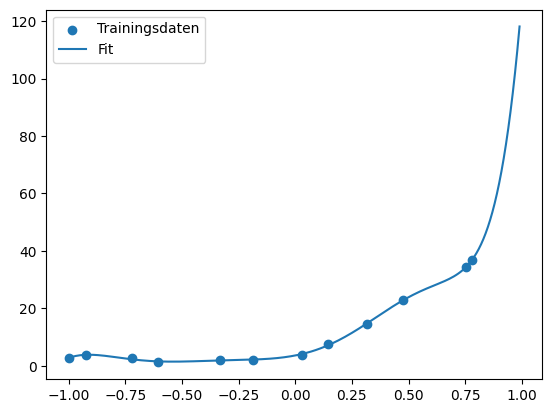

In [28]:
from numpy.polynomial import Polynomial

w_linreg = lin_reg_regularized(phi(x_train_scaled, 8), y_train, 0.0)
p = Polynomial(tuple(w_linreg))

plt.scatter(x_train_scaled, y_train, label='Trainingsdaten')
plt.plot(np.arange(-1, 1, 0.01), p(np.arange(-1, 1, 0.01)), label='Fit')
plt.legend(loc='upper left')
plt.show()

(5) Wir untersuchen jetzt eine Reihe von Lernmodellen, die sich nur in der Stärke der Regularisierung (parametrisiert durch $\lambda$) voneinander unterscheiden. Implementieren Sie dazu zunächst eine Funktion, die Datenpaare $(x, y)$ sowie eine Hypothese $f$ entgegennimmt, und den mittleren quadratischen Fehler zwischen $f(x)$ und $y$ zurückgibt.

In [29]:
def mqe(data_tuples: tuple[float, float], f: Polynomial, debug: bool | None = False) -> float:
    s: int = 0
    n: int = 0
    
    if debug: print('{:>8s} {:>8s}'.format('f(x)', 'y'))
    for x, y in data_tuples:
        if debug: print('{:8.4f} {:8.4f}'.format(*f(x), *y))
        s += (f(x) - y) ** 2
        n += 1
    return s / n

D = zip(x_train_scaled, y_train)
print(mqe(D, p))

[0.05778048]


(6) Bestimmen Sie mit dem **Trainingsset** und regularisierter linearer Regression für jedes $\lambda \in \{0, 0.05, 0.1,\ldots, 2 \}$ und $Q=8$ ein Polynom (Modell), das die Daten beschreibt. Bestimmen Sie mithilfe Ihrer Funktion aus Schritt (5) für jedes Ihrer Modelle den mittleren quadratischen Fehler $E_\text{val}$ auf dem **Validierungsset**. Sie erhalten also für jedes Modell $\lambda$ einen Validierungsfehler $E_\text{val}(\lambda)$.

In [37]:
# Transformiere Validierungsset in ein Array von 2er-Tupeln [(x1, y1), (x2, y2), ...] 
D = np.rec.fromarrays([x_val_scaled[:,0], y_val[:,0]])

# Erstelle Tabelle Lambda vs. E_val
validations: list[tuple[float, float]] = []
print('{:6s} | {:>8s}'.format('Lambda', 'E_val'))
print('-'*17)
for alpha in np.arange(0, 2.05, step=0.05):
    _w = lin_reg_regularized(phi(x_train_scaled, 8), y_train, alpha)
    _modell = Polynomial(_w)
    _mqe = mqe(D, _modell)
    validations.append((alpha, _mqe))
    print('{:6.2f} | {:8.3f}'.format(alpha, _mqe))

Lambda |    E_val
-----------------


NameError: name 'X_y' is not defined

(7) Visualisieren Sie $E_\text{val}(\lambda)$ in Abhängigkeit von $\lambda$. Wie interpretieren Sie den Plot? (1-2 Sätze)

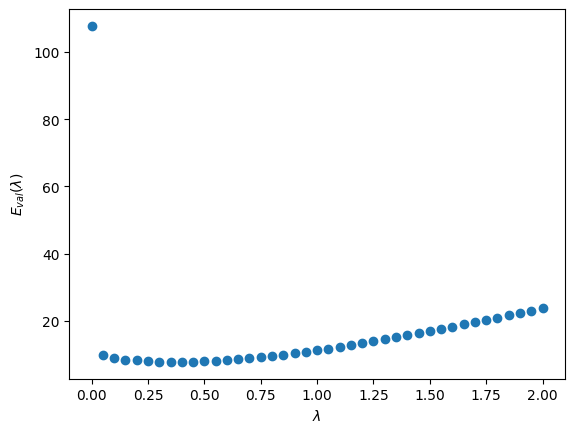

In [31]:
Evals = np.rec.fromrecords(validations, names='x,y')
plt.scatter(Evals.x , Evals.y)
plt.xlabel("$\lambda$")
plt.ylabel("$E_{val}(\lambda)$")
plt.show()

(8) Betrachten Sie Ihre Visualisierung aus Schritt (7). Welchen Parameterwert $\lambda$ wählen Sie aus für Ihr bestes Modell? (1 Wort)

Für das Beste Modell wählen wir $\lambda = 0.4$. Dies ist der Wert, bei dem der Validierungsfehler am geringsten ist.

(9) Visualisieren Sie Ihr finales Modell (finales Polynom) zusammen mit den Trainings- und Validierungsdaten in einem Plot. Beurteilen Sie, ob Ihr Modell die Validierungsdaten gut approximiert. (1 Satz)

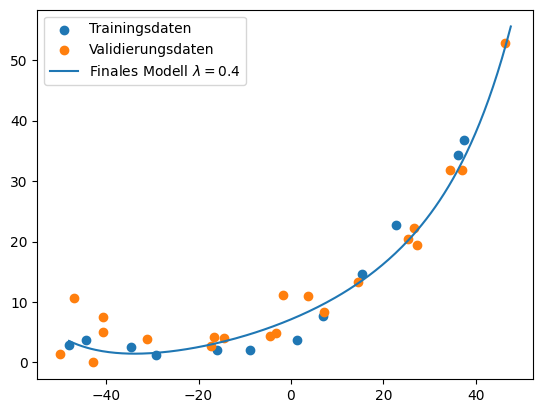

In [32]:
w_linreg = lin_reg_regularized(phi(x_train_scaled, 8), y_train, 0.4)
p = Polynomial(tuple(w_linreg))

plt.scatter(x_train, y_train, label='Trainingsdaten')
plt.scatter(x_val, y_val, label='Validierungsdaten')
#plt.scatter(x_test, y_test, label='Testdaten')
plt.plot(np.arange(-1, 1, 0.01)*x_max, p(np.arange(-1, 1, 0.01)), label='Finales Modell $\lambda = 0.4$')
plt.legend(loc='upper left')
plt.show()

Das Modell approximiert die Validierungsdaten gut. 

### 5.2 Staudamm (Teil 2) - Gittersuche

Sie haben in der Vorlesung gelernt, dass es viele verschiedene Regularisierungstechniken gibt. Unter anderem lässt sich die strikte Beschränkung der Modellordnung (hier: der Ordnung der Polynome) als Regularisierung unseres Hypothesensets interpretieren. In dieser Übungsaufgabe werden wir uns anschauen, welche Auswirkung die Polynomordnung auf die Qualität unserer Fits auf die Daten von Übung 5.1. haben.

* Dies ist eine Fortsetzung der Übung 5.1.

**Ihre Aufgaben**

(1) Setzen Sie $\lambda=0$. Bestimmen Sie für $Q\in\{0, 1, \ldots, 8\}$ je ein Polynom (Modell) über das **Trainingsset**. Benutzen Sie das **Validierungsset**, um $E_\text{val}(Q)$ zu bestimmen.

In [41]:
# @TODO: Polynom Ordnung 0
for _Q in np.arange(0, 8, step=1):
    _w = lin_reg_regularized(phi(x_train_scaled, _Q), y_train, 0)
    _modell = Polynomial(_w)
    _mqe = mqe(D, _modell)
    validations.append((alpha, _mqe))
    print('{:2d} | {:8.3f}'.format(_Q, _mqe))

ValueError: X^T @ X ist nicht invertierbar

(2) Visualisieren Sie (wie bei Übung 5.1 im Schritt 7) $E_\text{val}(Q)$ in Abhängigkeit der Polynomordnung $Q$. Wie interpretieren Sie den Plot? (1-2 Sätze) Für welches beste Modell entscheiden Sie sich? (1 Wort)

(3) Soweit haben wir gesehen, dass unsere Lernmodelle durch $\lambda$ und $Q$ parametrisiert werden. Ein folgerichtiger Schritt ist es also, zu untersuchen, für welche Kombination aus $(Q,\lambda)$-Parametern wir das beste Modell erhalten. **Dieser Vorgang wird Gittersuche genannt**, da Sie sich die Parameterkombinationen als Knoten eines (je nach Parameteranzahl hochdimensionalen) Gitters vorstellen können. Sei $Q\in\{0, 1, \ldots, 8\}$ und $\lambda \in \{0, 0.5, 1, 1.5, \ldots, 10 \}$ gegeben. Bestimmen Sie für jede Kombination $(Q, \lambda)$ ein Modell mit dem Trainingsset und bestimmen $E_\text{val}(Q,\lambda)$ mit dem Validierungsset.

(4) Visualisieren Sie $E_\text{val}(Q,\lambda)$ ([diese](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) und [diese](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.colorbar.html) Funktionen können Ihnen dabei helfen). Bestimmen Sie Ihre finalen Parameter, indem Sie die Parameterkombination $\lambda$ und $Q$ auswählen, welche den niedrigsten Validierungsfehler erzielt.

(5) Dem Staudammbetreiber wollen Sie das bestmögliche (das finale) Modell ausliefern. Welches finale Modell liefern Sie dem Staudammbetreiber aus? Wie erhalten Sie es? (1-2 Sätze) Tipp: Wenn Sie sich unsicher sind, schlagen Sie in der Vorlesung 5 nach.

(6) Erstellen Sie gemäß Ihrer Überlegungen aus Schritt (5) Ihr finales Modell $g$. Ermitteln Sie den mittleren quadratischen Fehler $E_\text{test}$ auf dem **Testset** und geben ihn hier aus. Bitte stellen Sie kurz für sich fest, dass wir hier zum ersten Mal das Testset benutzen. Warum? (1 Satz)

(7) Visualisieren Sie Ihr finales Modell zusammen mit den Trainings-, Validierungs- und Testdaten in einem Plot. Beurteilen Sie, ob Ihr Modell die Testdaten gut approximiert (1 Satz).

### 5.3 Staudamm (Teil 3) - Kreuzvalidierung

* Dies ist eine Fortsetzung der Übung 5.2.

Stelle Sie sich vor, dass Sie nur wenig Datenpunkte zur Verfügung haben, um ein Modell für den Staudammbetreiber zu finden, welches die abfließende Wassermenge in Abhängigkeit vom Füllstand des Stausees vorhersagen soll. Dennoch wollen Sie eine Validierung durchführen, um Hyperparameter zu bestimmen. 

Konkret: **Ihr Datensatz bestehe nur noch aus den Daten des Trainingssets.**

In dieser Übung werden wir die **L**eave-**O**ne-**O**ut Kreuzvalidierung (LOO-CV) implementieren, um mit ihrer Hilfe die Ordnung $Q$ unseres finalen Modells zu wählen. Wir werden also Kreuzvalidierung für die Modellselektion einsetzen.

**Ihre Aufgaben**

(1) Implementieren Sie eine Funktion, die Ihnen den Kreuzvalidierungsfehler $E_\text{CV}(Q)$ für ein Modell mit gegebener Polynomordnung $Q$ zurückgibt. Schlagen Sie dazu in den Vorlesungsfolien nach, um zu verstehen, wie $E_\text{CV}$ aus den punktweisen Fehlern $\text{e}_n$ bestimmt wird. Hinweis: Ihre Funktion muss für die Bestimmung jedes punktweisen Fehlers $\text{e}_n$ ein neues Modell trainieren.

(2) Setzen Sie den Regularisierungsparameter $\lambda=0$. Ermitteln Sie $E_\text{CV}(Q)$ für $Q\in\{0, 1, \ldots, 9\}$.

(3) Visualisieren Sie $E_\text{CV}$ als Funktion von $Q$. Für welchen Wert $Q$ wird $E_\text{CV}$ minimiert? 

(4) Vergleichen Sie den im Schritt (3) ermittelten Wert für $Q$ Ihres finales Modells mit dem Wert aus Übung 5.2 Schritt (2).

(5) Vergleichen Sie den im Schritt (3) ermittelten Fehler $E_\text{CV}$ für Ihr bestes Modell ($Q$) mit dem Fehler $E_\text{val}$ für Ihr bestes Modell aus Übung 5.2 Schritt (2).